# Pet breed classification

This is an experiment building an image classifier using transfer learning, with a
forward-forward network for the classifier head. Using Mobilnet_v2 to do feature 
extraction from lareger/color images, and then feed the resulting latent images through
the FF network.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

from layers import FFDense
from img_classifier import ImageClassifier
import utils


c:\Users\karen\myprojects\forward-forward\fwd-fwd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the pretrained CNN (Mobilenet_v2)

In [2]:
module_selection = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

extract_layer = hub.KerasLayer(MODULE_HANDLE,
                              input_shape=IMAGE_SIZE + (3,), 
                              output_shape=[FV_SIZE],
                              trainable=False)
     
extractor = Sequential([extract_layer])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Collect data

In [3]:
(raw_train, raw_test), metadata = tfds.load('OxfordIIITPet',
                                            split=['train', 'test'],
                                            with_info=True,
                                            as_supervised=True)

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE)

Look at a sample of the images

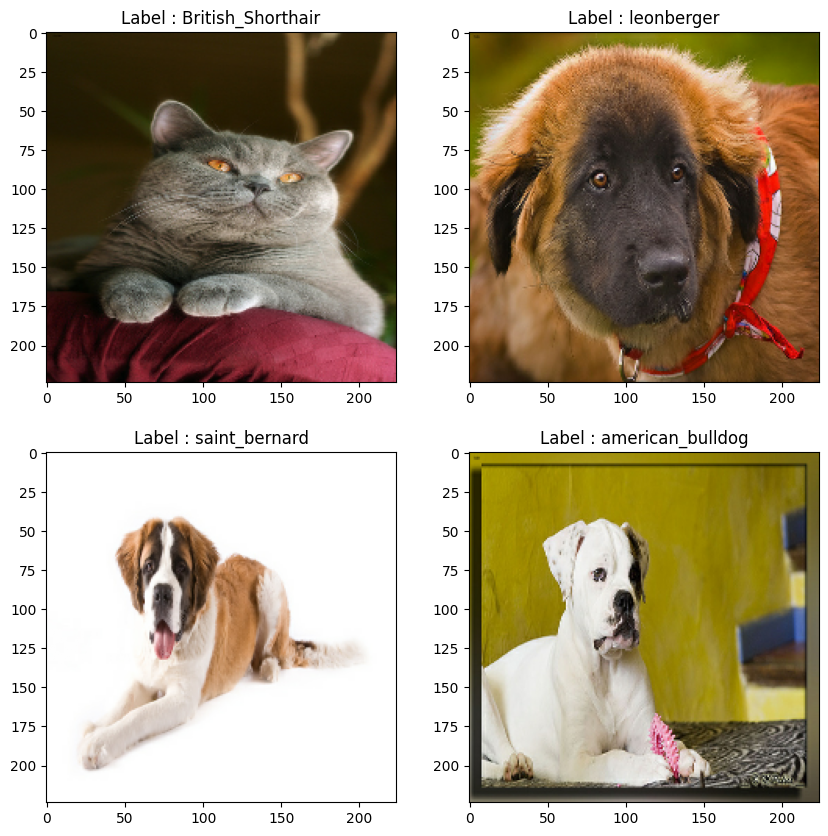

In [4]:
ds = raw_train.take(100)
imgs = []
labels = []
for image, label in tfds.as_numpy(ds):
  image = tf.image.resize(image, (224, 224)) / 255.0
  imgs.append(image)
  labels.append(label)
imgs = np.array(imgs)
labels = np.array(labels)

utils.show_samples(imgs, labels, 4, class_names)

## Train our classifier

In [5]:
clf = ImageClassifier(extractor, [200, 200], len(class_names))
hist = clf.fit(train_batches)

Epoch 1
[====================] - time=4m 35s - loss=0.5731
Epoch 2
[====================] - time=4m 29s - loss=0.4633
Epoch 3
[====================] - time=4m 29s - loss=0.4114
Epoch 4
[====================] - time=4m 33s - loss=0.3802
Epoch 5
[====================] - time=4m 35s - loss=0.3598


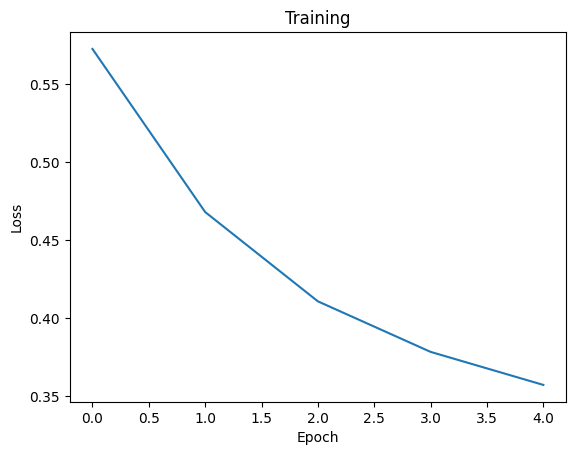

In [7]:
plt.plot(hist)
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()